In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
import psycopg2
from psycopg2 import sql
from psycopg2.extensions import adapt, register_adapter, AsIs
from sqlalchemy import create_engine
import getpass

In [ ]:
database = 'f24t03'
user = 'jsmm8'
password = getpass.getpass("Type password and hit enter: ")

Type password and hit enter: ········


In [ ]:
try:
    # Connect to the PostgreSQL database
    connection = psycopg2.connect(dbname=database, user=user, password=password, host='pgsql')
    cursor = connection.cursor()

    # Execute a query to get all table names
    cursor.execute("""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'public';
    """)
    
    # Fetch all results
    tables = cursor.fetchall()

    # Print the table names
    print("Tables in the database:")
    for table in tables:
        print(table[0])

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()

Tables in the database:
ethnicity
year_built
education_levels
tenure_by_bedrooms
tenure_by_kitchen
tenure_by_plumbing
rooms
imputed_median_house_value
education_categories
demographics_master
model_features_data
year_structure_built
mortgage
tenure_by_rooms
income_data_processed
race_data_processed
housing_stats_data
race_migration_data
merged_new_house_data
income_pct_change
bedrooms
educational_attainment
employment_status
geo_mobility
home_value
house_heating_fuel
household_income
internet_subscription
income_to_poverty_ratio
median_home_value
median_household_income
median_rooms_by_tenure
occupancy_status
plumbing_facilities
poverty_status
mortgage_status
education_data_processed
housing_pct_change_stats_data


In [ ]:
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=password)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the median_household_income table
query = "SELECT * FROM housing_stats_data where year in (2020,2021,2022);"

# Use pandas to read the SQL query into a DataFrame
try:
    df = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
df.shape

I am able to connect to the database
Data extracted successfully!


(15093, 45)

In [7]:
df_2022 = df[df['year'] == 2022]

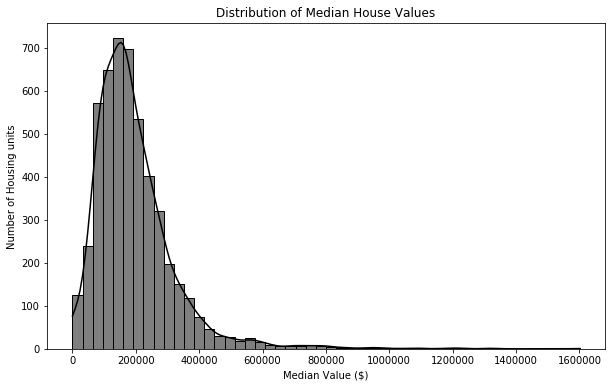

In [8]:
# Housing Value Trends
plt.figure(figsize=(10, 6))
sns.histplot(df_2022['median_value'], bins=50, kde=True, color='black')
plt.title('Distribution of Median House Values')
plt.xlabel('Median Value ($)')
plt.ylabel('Number of Housing units')
plt.show()

In [9]:
# creating new dataset with percentage changes

In [10]:
df_geo = df[['geo_id', 'block_group', 'census_tract', 'county', 'state']]

filtered_data = df[['geo_id', 'year', 'pct_occupied', 'pct_vacant', 'pct_owner_occupied', 'pct_rental']]
pivoted_data = filtered_data.pivot(index='geo_id', columns='year')

results = pd.DataFrame()
for metric in ['pct_occupied', 'pct_vacant', 'pct_owner_occupied', 'pct_rental']:
    results[f'{metric}_chg_20_21'] = (pivoted_data[metric][2021] - pivoted_data[metric][2020]).round(2)
    results[f'{metric}_chg_21_22'] = (pivoted_data[metric][2022] - pivoted_data[metric][2021]).round(2)
    results[f'{metric}_chg_20_22'] = (pivoted_data[metric][2022] - pivoted_data[metric][2020]).round(2)

df_new = results.merge(
    df_geo[['geo_id', 'block_group', 'census_tract', 'county', 'state']].drop_duplicates(),
    on='geo_id',
    how='left'
)

df_new.head()

,geo_id,pct_occupied_chg_20_21,pct_occupied_chg_21_22,pct_occupied_chg_20_22,pct_vacant_chg_20_21,pct_vacant_chg_21_22,pct_vacant_chg_20_22,pct_owner_occupied_chg_20_21,pct_owner_occupied_chg_21_22,pct_owner_occupied_chg_20_22,pct_rental_chg_20_21,pct_rental_chg_21_22,pct_rental_chg_20_22,block_group,census_tract,county,state
0,1500000US290019501001,4.38,-7.49,-3.10,-4.38,7.49,3.10,-0.85,-1.41,-2.25,0.85,1.41,2.25,Block Group 1,Census Tract 9501,Adair County,Missouri
1,1500000US290019501002,-1.01,4.44,3.43,1.01,-4.44,-3.43,0.49,-2.82,-2.33,-0.49,2.82,2.33,Block Group 2,Census Tract 9501,Adair County,Missouri
2,1500000US290019501003,0.47,2.39,2.87,-0.47,-2.39,-2.87,-1.74,-1.15,-2.89,1.74,1.15,2.89,Block Group 3,Census Tract 9501,Adair County,Missouri
3,1500000US290019502001,-6.91,-0.97,-7.88,6.91,0.97,7.88,-0.93,3.49,2.56,0.93,-3.49,-2.56,Block Group 1,Census Tract 9502,Adair County,Missouri
4,1500000US290019502002,4.02,1.47,5.49,-4.02,-1.47,-5.49,0.05,-0.29,-0.23,-0.05,0.29,0.23,Block Group 2,Census Tract 9502,Adair County,Missouri


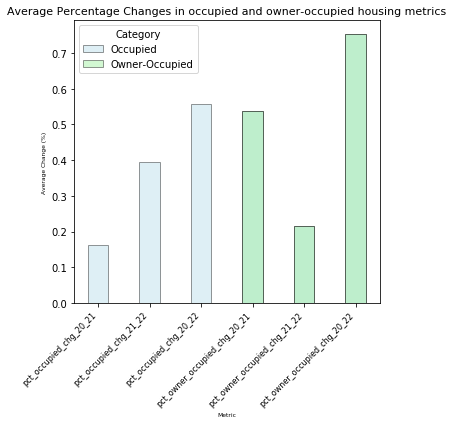

In [11]:
pct_cols = [col for col in df_new.columns if 'pct' in col and 'chg' in col]
columns_to_drop = ['pct_value_chg_20_21', 'pct_value_chg_21_22', 'pct_value_chg_20_22', 
                   'pct_vacant_chg_20_21','pct_vacant_chg_21_22', 'pct_vacant_chg_20_22', 
                   'pct_rental_chg_20_21', 'pct_rental_chg_21_22', 'pct_rental_chg_20_22']
pct_cols = [col for col in pct_cols if col not in columns_to_drop]
housing_pct_means = df_new[pct_cols].mean()

# Assuming housing_pct_means is already calculated
occupied_cols = [col for col in pct_cols if 'occupied' in col]  # Columns related to 'occupied'
owner_occupied_cols = [col for col in pct_cols if 'owner_occupied' in col]  # Columns related to 'owner-occupied'

# Create separate Series for plotting
occupied_means = housing_pct_means[occupied_cols]
owner_occupied_means = housing_pct_means[owner_occupied_cols]

# Combine the data for a grouped barplot
data = {
    'Metric': occupied_cols + owner_occupied_cols,
    'Category': ['Occupied'] * len(occupied_cols) + ['Owner-Occupied'] * len(owner_occupied_cols),
    'Value': list(occupied_means) + list(owner_occupied_means),
}

# Create DataFrame for better control over plotting
df1 = pd.DataFrame(data)

# Plot the barplot
plt.figure(figsize=(6,6))
categories = ['Occupied', 'Owner-Occupied']
colors = ['lightblue', 'lightgreen']

for i, category in enumerate(categories):
    subset = df1[df1['Category'] == category]
    plt.bar(
        subset['Metric'],
        subset['Value'],
        color=colors[i],
        label=category,
        width=0.4,
        edgecolor='black',
        alpha=0.4,
    )

plt.title('Average Percentage Changes in occupied and owner-occupied housing metrics', fontsize=11)
plt.ylabel('Average Change (%)', fontsize=6)
plt.xlabel('Metric', fontsize=6)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend(title="Category")
plt.tight_layout()
plt.show()

In [12]:
#2 Categories +,-, neutral for consistent change

In [13]:
def determine_consistency(row):
    if (row['pct_occupied_chg_20_21'] == 0 and row['pct_occupied_chg_21_22'] == 0) or \
       (row['pct_vacant_chg_20_21'] == 0 and row['pct_vacant_chg_21_22'] == 0):
        return 'zero_change'
    
    elif row['pct_occupied_chg_20_21'] > 0 and row['pct_occupied_chg_21_22'] > 0:
        return 'occ_pos'

    elif row['pct_vacant_chg_20_21'] > 0 and row['pct_vacant_chg_21_22'] > 0:
        return 'vac_pos'

    else:
        return 'Inconsistent'

df_new['housing_consistency'] = df_new.apply(determine_consistency, axis=1)

print(df_new['housing_consistency'].value_counts())
print(df_new['housing_consistency'].value_counts().sum())

Inconsistent    2326
occ_pos         1120
vac_pos          809
zero_change      776
Name: housing_consistency, dtype: int64
5031


In [14]:
def determine_consistency(row):
    if (row['pct_owner_occupied_chg_20_21'] == 0 and row['pct_owner_occupied_chg_21_22'] == 0) or \
       (row['pct_rental_chg_20_21'] == 0 and row['pct_rental_chg_21_22'] == 0):
        return 'zero_change'
    
    elif row['pct_owner_occupied_chg_20_21'] > 0 and row['pct_owner_occupied_chg_21_22'] > 0:
        return 'own_occ_pos'
    
    elif row['pct_rental_chg_20_21'] > 0 and row['pct_rental_chg_21_22'] > 0:
        return 'ren_pos'
    
    else:
        return 'Inconsistent'

df_new['occupancy_consistency'] = df_new.apply(determine_consistency, axis=1)

print(df_new['occupancy_consistency'].value_counts())
print(df_new['occupancy_consistency'].value_counts().sum())

Inconsistent    2569
own_occ_pos     1243
ren_pos         1030
zero_change      189
Name: occupancy_consistency, dtype: int64
5031


In [15]:
df_new.head()

,geo_id,pct_occupied_chg_20_21,pct_occupied_chg_21_22,pct_occupied_chg_20_22,pct_vacant_chg_20_21,pct_vacant_chg_21_22,pct_vacant_chg_20_22,pct_owner_occupied_chg_20_21,pct_owner_occupied_chg_21_22,pct_owner_occupied_chg_20_22,pct_rental_chg_20_21,pct_rental_chg_21_22,pct_rental_chg_20_22,block_group,census_tract,county,state,housing_consistency,occupancy_consistency
0,1500000US290019501001,4.38,-7.49,-3.10,-4.38,7.49,3.10,-0.85,-1.41,-2.25,0.85,1.41,2.25,Block Group 1,Census Tract 9501,Adair County,Missouri,Inconsistent,ren_pos
1,1500000US290019501002,-1.01,4.44,3.43,1.01,-4.44,-3.43,0.49,-2.82,-2.33,-0.49,2.82,2.33,Block Group 2,Census Tract 9501,Adair County,Missouri,Inconsistent,Inconsistent
2,1500000US290019501003,0.47,2.39,2.87,-0.47,-2.39,-2.87,-1.74,-1.15,-2.89,1.74,1.15,2.89,Block Group 3,Census Tract 9501,Adair County,Missouri,occ_pos,ren_pos
3,1500000US290019502001,-6.91,-0.97,-7.88,6.91,0.97,7.88,-0.93,3.49,2.56,0.93,-3.49,-2.56,Block Group 1,Census Tract 9502,Adair County,Missouri,vac_pos,Inconsistent
4,1500000US290019502002,4.02,1.47,5.49,-4.02,-1.47,-5.49,0.05,-0.29,-0.23,-0.05,0.29,0.23,Block Group 2,Census Tract 9502,Adair County,Missouri,occ_pos,Inconsistent


In [16]:
#3 Housing change and occupancy change

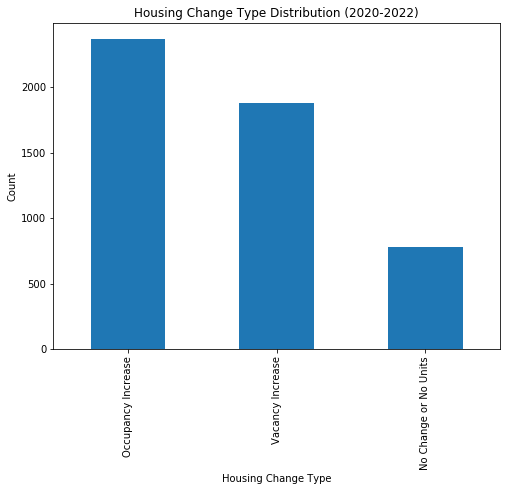

In [17]:
def classify_change(row):
    if row['pct_occupied_chg_20_22'] > 0:
        return "Occupancy Increase"
    elif row['pct_vacant_chg_20_22'] > 0:
        return "Vacancy Increase"
    else:
        return "No Change or No Units"

df_new['housing_chg_20_22'] = df_new.apply(classify_change, axis=1)

plt.figure(figsize=(8, 6))
df_new['housing_chg_20_22'].value_counts().plot(kind='bar')
plt.title('Housing Change Type Distribution (2020-2022)')
plt.xlabel('Housing Change Type')
plt.ylabel('Count')
plt.show()

In [18]:
df_new['housing_chg_20_22'].value_counts().sum()

5031

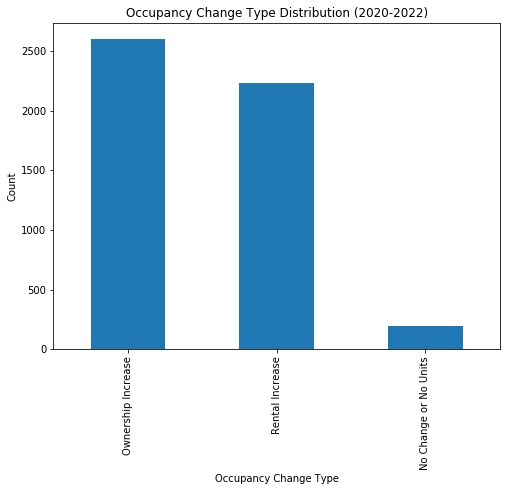

In [19]:
def classify_change(row):
    if row['pct_rental_chg_20_22'] > 0:
        return "Rental Increase"
    elif row['pct_owner_occupied_chg_20_22'] > 0:
        return "Ownership Increase"
    else:
        return "No Change or No Units"

df_new['occupancy_chg_20_22'] = df_new.apply(classify_change, axis=1)

plt.figure(figsize=(8, 6))
df_new['occupancy_chg_20_22'].value_counts().plot(kind='bar')
plt.title('Occupancy Change Type Distribution (2020-2022)')
plt.xlabel('Occupancy Change Type')
plt.ylabel('Count')
plt.show()

In [20]:
df_new['occupancy_chg_20_22'].value_counts().sum()

5031

In [21]:
# Median Household Value Change: 2020 - 2022
median_values = df.pivot(index='geo_id', columns='year', values='median_value')

median_values['pct_value_chg_20_21'] = (((median_values[2021] - median_values[2020]) / median_values[2020]) * 100).round(2)
median_values['pct_value_chg_21_22'] = (((median_values[2022] - median_values[2021]) / median_values[2021]) * 100).round(2)
median_values['pct_value_chg_20_22'] = (((median_values[2022] - median_values[2020]) / median_values[2020]) * 100).round(2)

df_new = df_new.merge(
    median_values[['pct_value_chg_20_21', 'pct_value_chg_21_22', 'pct_value_chg_20_22']],
    how='left',
    left_on='geo_id',
    right_index=True
)

In [22]:
df_new

,geo_id,pct_occupied_chg_20_21,pct_occupied_chg_21_22,pct_occupied_chg_20_22,pct_vacant_chg_20_21,pct_vacant_chg_21_22,pct_vacant_chg_20_22,pct_owner_occupied_chg_20_21,pct_owner_occupied_chg_21_22,pct_owner_occupied_chg_20_22,...,census_tract,county,state,housing_consistency,occupancy_consistency,housing_chg_20_22,occupancy_chg_20_22,pct_value_chg_20_21,pct_value_chg_21_22,pct_value_chg_20_22
0,1500000US290019501001,4.38,-7.49,-3.10,-4.38,7.49,3.10,-0.85,-1.41,-2.25,...,Census Tract 9501,Adair County,Missouri,Inconsistent,ren_pos,Vacancy Increase,Rental Increase,4.08,20.80,25.72
1,1500000US290019501002,-1.01,4.44,3.43,1.01,-4.44,-3.43,0.49,-2.82,-2.33,...,Census Tract 9501,Adair County,Missouri,Inconsistent,Inconsistent,Occupancy Increase,Rental Increase,0.34,12.30,12.68
2,1500000US290019501003,0.47,2.39,2.87,-0.47,-2.39,-2.87,-1.74,-1.15,-2.89,...,Census Tract 9501,Adair County,Missouri,occ_pos,ren_pos,Occupancy Increase,Rental Increase,-1.05,11.15,9.99
3,1500000US290019502001,-6.91,-0.97,-7.88,6.91,0.97,7.88,-0.93,3.49,2.56,...,Census Tract 9502,Adair County,Missouri,vac_pos,Inconsistent,Vacancy Increase,Ownership Increase,8.50,9.30,18.59
4,1500000US290019502002,4.02,1.47,5.49,-4.02,-1.47,-5.49,0.05,-0.29,-0.23,...,Census Tract 9502,Adair County,Missouri,occ_pos,Inconsistent,Occupancy Increase,Rental Increase,60.56,6.34,70.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5026,1500000US295101277001,-2.67,-0.12,-2.79,2.67,0.12,2.79,14.71,0.43,15.13,...,Census Tract 1277,St. Louis city,Missouri,vac_pos,own_occ_pos,Vacancy Increase,Ownership Increase,19.00,101.77,140.10
5027,1500000US295101277002,1.45,-0.87,0.58,-1.45,0.87,-0.58,-5.21,-10.68,-15.89,...,Census Tract 1277,St. Louis city,Missouri,Inconsistent,ren_pos,Occupancy Increase,Rental Increase,-1.16,15.44,14.11
5028,1500000US295101277003,-6.07,22.67,16.60,6.07,-22.67,-16.60,-1.80,8.87,7.08,...,Census Tract 1277,St. Louis city,Missouri,Inconsistent,Inconsistent,Occupancy Increase,Ownership Increase,62.76,52.06,147.50
5029,1500000US295101278001,2.08,-4.02,-1.94,-2.08,4.02,1.94,0.83,-1.82,-0.99,...,Census Tract 1278,St. Louis city,Missouri,Inconsistent,Inconsistent,Vacancy Increase,Rental Increase,103.21,7871.74,16099.43


In [23]:
df_new.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

In [24]:
df_new.describe()

,pct_occupied_chg_20_21,pct_occupied_chg_21_22,pct_occupied_chg_20_22,pct_vacant_chg_20_21,pct_vacant_chg_21_22,pct_vacant_chg_20_22,pct_owner_occupied_chg_20_21,pct_owner_occupied_chg_21_22,pct_owner_occupied_chg_20_22,pct_rental_chg_20_21,pct_rental_chg_21_22,pct_rental_chg_20_22,pct_value_chg_20_21,pct_value_chg_21_22,pct_value_chg_20_22
count,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000
mean,0.162343,0.394566,0.556869,-0.182220,-0.414442,-0.596623,0.537317,0.216321,0.753679,-0.557193,-0.236198,-0.793433,6.544486,18.326633,26.069020
std,5.348326,5.243463,7.253806,5.158456,5.048737,6.971061,6.317378,6.727553,9.061467,6.471134,6.577454,9.058072,32.534955,116.388634,229.621836
min,-100.000000,-100.000000,-100.000000,-51.250000,-34.970000,-59.520000,-45.450000,-100.000000,-100.000000,-100.000000,-39.570000,-100.000000,-100.000000,-100.000000,-100.000000
25%,-1.445000,-1.160000,-2.465000,-2.005000,-2.395000,-3.980000,-2.600000,-2.970000,-3.835000,-3.635000,-3.275000,-5.455000,-0.820000,5.840000,8.325000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.180000,0.000000,0.330000,-0.180000,0.000000,-0.330000,3.350000,13.770000,18.920000
75%,2.005000,2.395000,3.980000,1.440000,1.155000,2.445000,3.630000,3.275000,5.450000,2.600000,2.960000,3.830000,9.625000,21.670000,29.990000
max,51.250000,34.970000,59.520000,76.060000,52.130000,58.060000,40.890000,39.570000,66.430000,45.450000,40.630000,49.840000,1288.320000,7871.740000,16099.430000


In [25]:
housing_pct_change_stats_data = df_new.copy()

In [28]:
housing_pct_change_stats_data.columns

Index(['geo_id', 'pct_occupied_chg_20_21', 'pct_occupied_chg_21_22',
       'pct_occupied_chg_20_22', 'pct_vacant_chg_20_21',
       'pct_vacant_chg_21_22', 'pct_vacant_chg_20_22',
       'pct_owner_occupied_chg_20_21', 'pct_owner_occupied_chg_21_22',
       'pct_owner_occupied_chg_20_22', 'pct_rental_chg_20_21',
       'pct_rental_chg_21_22', 'pct_rental_chg_20_22', 'block_group',
       'census_tract', 'county', 'state', 'housing_consistency',
       'occupancy_consistency', 'housing_chg_20_22', 'occupancy_chg_20_22',
       'pct_value_chg_20_21', 'pct_value_chg_21_22', 'pct_value_chg_20_22'],
      dtype='object')

In [29]:
import psycopg2
from psycopg2 import sql
from psycopg2.extensions import adapt, register_adapter, AsIs
from sqlalchemy import create_engine,text
import getpass

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#Create Table
mypasswd = getpass.getpass("Enter your database password: ")

# Database connection details
database = "f24t03"
user = "jsmm8"
password = mypasswd
host = "pgsql"

# Create a connection to the database using SQLAlchemy for easier inserts
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}/{database}')

# Connect and create/drop the table, then insert data in chunks
try:
    # Connect to the database
    conn = psycopg2.connect(database=database, user=user, host=host, password=password)
    cursor = conn.cursor()
    print("Connected to the database.")

    # Drop the table if it exists
    cursor.execute("DROP TABLE IF EXISTS housing_pct_change_stats_data;")
    print("Dropped the housing_pct_change_stats_data table if it existed.")

    # Create the <Table Name> table
    create_table_query = """
CREATE TABLE housing_pct_change_stats_data (
    geo_id VARCHAR(255) PRIMARY KEY,
    pct_occupied_chg_20_21 FLOAT,
    pct_occupied_chg_21_22 FLOAT,
    pct_occupied_chg_20_22 FLOAT,
    pct_vacant_chg_20_21 FLOAT,
    pct_vacant_chg_21_22 FLOAT,
    pct_vacant_chg_20_22 FLOAT,
    pct_owner_occupied_chg_20_21 FLOAT,
    pct_owner_occupied_chg_21_22 FLOAT,
    pct_owner_occupied_chg_20_22 FLOAT,
    pct_rental_chg_20_21 FLOAT,
    pct_rental_chg_21_22 FLOAT,
    pct_rental_chg_20_22 FLOAT,
    block_group VARCHAR(255),
    census_tract VARCHAR(255),
    county VARCHAR(255),
    state VARCHAR(255),
    housing_consistency VARCHAR(255),
    occupancy_consistency VARCHAR(255),
    housing_chg_20_22 VARCHAR(255),
    occupancy_chg_20_22 VARCHAR(255),
    pct_value_chg_20_21 FLOAT,
    pct_value_chg_21_22 FLOAT,
    pct_value_chg_20_22 FLOAT
);
    """
    cursor.execute(create_table_query)
    conn.commit()
    print("Created the housing_pct_change_stats_data table.")

    # Insert data from <dataframe> in chunks
    chunk_size = 500
    for start in range(0, len(housing_pct_change_stats_data), chunk_size):
        chunk = housing_pct_change_stats_data.iloc[start:start + chunk_size]
        chunk.to_sql('housing_pct_change_stats_data', engine, if_exists='append', index=False)
        print(f"Uploaded a chunk of {len(chunk)} records to the housing_pct_change_stats_data table.")

    print("Data uploaded successfully.")

    # Query the inserted data to confirm
    query = "SELECT * FROM housing_pct_change_stats_data;"
    housing_pct_change_stats_data = pd.read_sql(query, conn)
    print("Data extracted successfully! DataFrame shape:", housing_pct_change_stats_data.shape)

except Exception as e:
    print("An error occurred:", e)

finally:
    # Ensure that the cursor and connection are closed
    if cursor:
        cursor.close()
    if conn:
        conn.close()

Enter your database password: ········
Connected to the database.
Dropped the housing_pct_change_stats_data table if it existed.
Created the housing_pct_change_stats_data table.
Uploaded a chunk of 500 records to the housing_pct_change_stats_data table.
Uploaded a chunk of 500 records to the housing_pct_change_stats_data table.
Uploaded a chunk of 500 records to the housing_pct_change_stats_data table.
Uploaded a chunk of 500 records to the housing_pct_change_stats_data table.
Uploaded a chunk of 500 records to the housing_pct_change_stats_data table.
Uploaded a chunk of 500 records to the housing_pct_change_stats_data table.
Uploaded a chunk of 500 records to the housing_pct_change_stats_data table.
Uploaded a chunk of 500 records to the housing_pct_change_stats_data table.
Uploaded a chunk of 500 records to the housing_pct_change_stats_data table.
Uploaded a chunk of 500 records to the housing_pct_change_stats_data table.
Uploaded a chunk of 31 records to the housing_pct_change_stats

In [ ]:
# SQL query to grant privileges
grant_privileges_query = "GRANT ALL PRIVILEGES ON TABLE housing_pct_change_stats_data TO ypd5yb, jsmm8, remcmf, jsmm8;"

with engine.connect() as connection:
        connection.execute(text(grant_privileges_query))
        print("Privileges granted successfully.")

Privileges granted successfully.
